In [27]:
import pandas as pd
import requests
import base64
import json
import time

In [28]:
import os
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
headers = {"Authorization": f"token {GITHUB_TOKEN}"}

for authenticated requests to the GitHub API

In [29]:
df = pd.read_csv("uid_workflows.csv")
print(df.shape)

(1528056, 17)


In [30]:
filtered_df = df[df['valid_workflow'] == True]

relevant_columns = ['repository', 'file_path', 'commit_hash', 'valid_yaml']
reduced_df = filtered_df[relevant_columns]

sample_df = reduced_df.sample(n=200000, random_state=42)


keeping only key columns that i need in this project

In [31]:
#no need to run this code since we're done with processing and splitting the data
chunk_size = 5000
for start in range(0, sample_df.shape[0], chunk_size):
    chunk = sample_df.iloc[start:start + chunk_size]

processing the dataset in chunks for memory efficient

In [7]:
workflow_df = sample_df[sample_df['file_path'].str.contains('.github/workflows') & sample_df['valid_yaml']]
print(workflow_df.shape)

(195351, 4)


In [32]:
def fetch_file_content(repository, commit_hash, file_path, retries=3, delay=5):
    url = f"https://api.github.com/repos/{repository}/contents/{file_path}?ref={commit_hash}"
    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                file_content = response.json().get('content')
                if file_content:
                    content = base64.b64decode(file_content).decode('utf-8')
                    print(f"Successfully fetched content for {file_path}")
                    return content
            else:
                print(f"Failed to fetch content for {file_path}, Status Code: {response.status_code}")
                return None
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            time.sleep(delay)  
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return None

    print(f"All retries failed for {file_path}")
    return None

URL construction (building a URL to access a specific file in a repository)
implementing up to 3 retries in case of network errors or rate limits
decoding Base64-encoded YAML content retrieved from the API

In [9]:
#if there's already data in the file
try:
    fetched_data = pd.read_pickle('fetched_yaml_data.pkl')
    print("Loaded existing fetched data from 'fetched_yaml_data.pkl'.")
except FileNotFoundError:
    #in case there's no fetched data
    fetched_data = pd.DataFrame(columns=['repository', 'commit_hash', 'file_path', 'yaml_content'])
    print("Starting fresh. No previous progress will be loaded.")

total_files = len(workflow_df)

for index, row in workflow_df.iterrows():
    # Skip if content has already been fetched
    if not ((fetched_data['repository'] == row['repository']) &
            (fetched_data['commit_hash'] == row['commit_hash']) &
            (fetched_data['file_path'] == row['file_path'])).any():

        yaml_content = fetch_file_content(row['repository'], row['commit_hash'], row['file_path'])

        fetched_data = pd.concat([fetched_data, pd.DataFrame({
            'repository': [row['repository']],
            'commit_hash': [row['commit_hash']],
            'file_path': [row['file_path']],
            'yaml_content': [yaml_content]
        })], ignore_index=True)

        #for the saving progress
        if len(fetched_data) % 100 == 0:
            fetched_data.to_pickle('fetched_yaml_data.pkl')
            print(f"Progress saved. {len(fetched_data)}/{total_files} files processed.")

fetched_data.to_pickle('fetched_yaml_data.pkl')
print("All YAML content fetched and saved to 'fetched_yaml_data.pkl'.")

#merge the data to the original dataset
workflow_df = workflow_df.merge(fetched_data, on=['repository', 'commit_hash', 'file_path'], how='left')
print("Merged fetched data with the original DataFrame.")


Loaded existing fetched data from 'fetched_yaml_data.pkl'.
All YAML content fetched and saved to 'fetched_yaml_data.pkl'.
Merged fetched data with the original DataFrame.


In [33]:
print(workflow_df.columns)

Index(['repository', 'file_path', 'commit_hash', 'valid_yaml', 'yaml_content'], dtype='object')


as we can see the yaml_content is succesully added to the dataset containing the fecthed data

In [12]:
workflow_df.to_csv("workflow.csv", index=False)

In [34]:
#for identifying missing data
missing_entries = workflow_df[workflow_df['yaml_content'].isna()]

In [35]:
missing_content_count = workflow_df['yaml_content'].isna().sum()
print(f"Number of missing yaml_content entries: {missing_content_count}")

Number of missing yaml_content entries: 0


In [ ]:
#no need to run this script since the missing value is 0 
for index, row in missing_entries.iterrows():
    yaml_content = fetch_file_content(row['repository'], row['commit_hash'], row['file_path'])
    workflow_df.at[index, 'yaml_content'] = yaml_content

In [36]:
#re-check the number of the missing values 
missing_content_count = workflow_df['yaml_content'].isna().sum()
print(f"Number of missing yaml_content entries: {missing_content_count}")

Number of missing yaml_content entries: 0


In [37]:
workflow_df.to_csv("workflow.csv", index=False)

In [23]:
#remove the failed to fetch data 
workflow_df = workflow_df.dropna(subset=['yaml_content'])

In [38]:
import yaml

def is_valid_yaml(content):
    try:
        yaml.safe_load(content)
        return True
    except yaml.YAMLError:
        return False

workflow_df['valid_yaml_content'] = workflow_df['yaml_content'].apply(is_valid_yaml)
print(workflow_df['valid_yaml_content'].value_counts())

valid_yaml_content
True     128331
False         4
Name: count, dtype: int64


making sure that yaml_content column contains properly structured YAML data

In [39]:
import yaml

def preprocess_yaml(content):
    if content:
        #handling the \t syntax error
        content = content.replace('\t', '    ')  
        return yaml.safe_load(content)
    return None

workflow_df['parsed_yaml'] = workflow_df['yaml_content'].apply(preprocess_yaml)

In [40]:
def extract_trigger_events(yaml_data):
    if isinstance(yaml_data, dict):
        #trying to access the on 
        if 'on' in yaml_data:
            return yaml_data['on']
        #else trying to access True key 
        elif True in yaml_data:
            return yaml_data[True]
    return None

workflow_df['trigger_events'] = workflow_df['parsed_yaml'].apply(extract_trigger_events)

In [41]:
print(workflow_df.columns)

Index(['repository', 'file_path', 'commit_hash', 'valid_yaml', 'yaml_content',
       'valid_yaml_content', 'parsed_yaml', 'trigger_events'],
      dtype='object')


to check that the trigger_event column is created succesfully (containing the extracted triggers)

In [43]:
#to check no missing values
print(workflow_df[['parsed_yaml', 'trigger_events']].isna().sum())

parsed_yaml       0
trigger_events    0
dtype: int64


In [44]:
#insight into the distribution of trigger events
print(workflow_df['trigger_events'].value_counts())

trigger_events
[push, pull_request]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         10056
{'push': {'branches': ['master']}, 'pull_request': {'branches': ['master']}}                                                                                                                                                                                          

In [45]:
#converting dictionaries to strings for unique value analysis
unique_trigger_events = workflow_df['trigger_events'].apply(str).unique()

In [46]:
event_types = ['push', 'pull_request', 'pull_request_target', 'manual', 'cron']

#checking if any of the events are in the trigger events
def contains_event_type(events):
    if isinstance(events, (list, dict)): 
        for event in event_types:
            if event in events:
                return True
    return False

available_events = workflow_df['trigger_events'].apply(contains_event_type)

for event in event_types:
    event_present = workflow_df['trigger_events'].apply(lambda x: event in str(x)).any()

In [47]:
import re

#handling special characters
cleaned_trigger_events = workflow_df['trigger_events'].astype(str).apply(
    lambda x: x if not re.search(r'[^a-zA-Z0-9_\s\[\]\{\}\':,]', x) else 'Special Case'
)


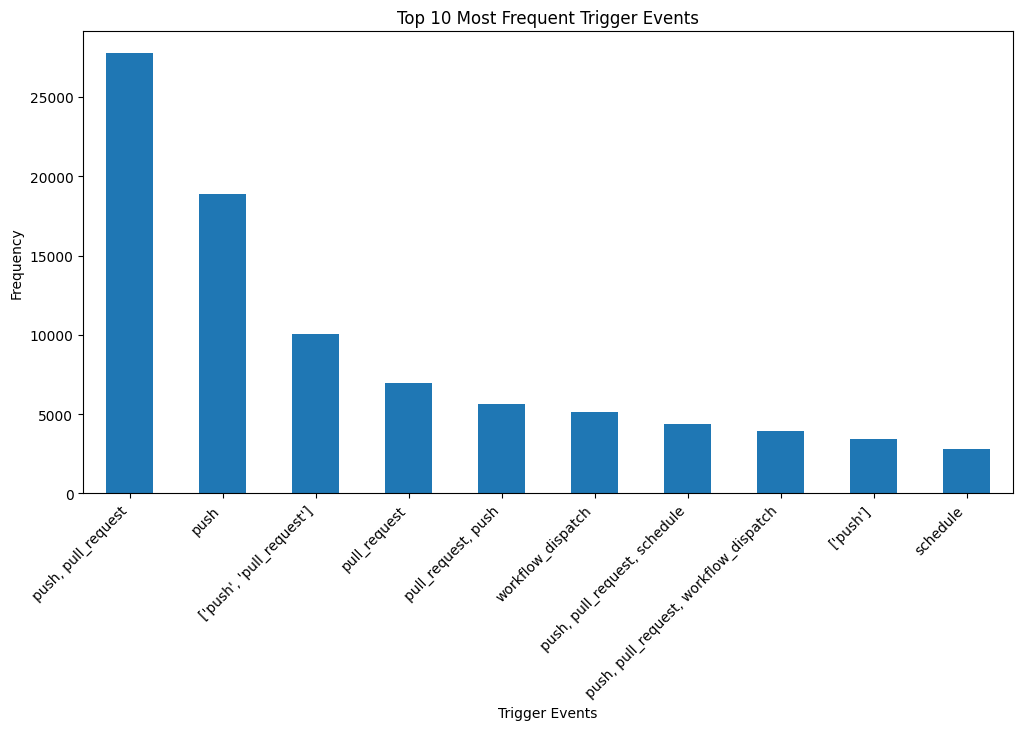

In [60]:
import matplotlib.pyplot as plt

#to visualize top 10 most frequent trigger events

workflow_df['cleaned_triggers'] = workflow_df['trigger_events'].apply(
    lambda x: ', '.join([key for key in x.keys()]) if isinstance(x, dict) else str(x)
)

trigger_event_strings = workflow_df['cleaned_triggers']
top_trigger_events = trigger_event_strings.value_counts().nlargest(10)

top_trigger_events.plot(kind='bar', figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Frequent Trigger Events")
plt.xlabel("Trigger Events")
plt.ylabel("Frequency")
plt.show()


In [51]:
#boolean columns for each trigger event
workflow_df['has_push_event'] = workflow_df['trigger_events'].astype(str).apply(lambda x: 'push' in x)
workflow_df['has_pull_request_event'] = workflow_df['trigger_events'].astype(str).apply(lambda x: 'pull_request' in x)
workflow_df['has_pull_request_target_event'] = workflow_df['trigger_events'].astype(str).apply(lambda x: 'pull_request_target' in x)
workflow_df['has_manual_event'] = workflow_df['trigger_events'].astype(str).apply(lambda x: 'workflow_dispatch' in x)
workflow_df['has_cron_event'] = workflow_df['trigger_events'].astype(str).apply(lambda x: 'schedule' in x or 'cron' in x)

In [52]:
print(workflow_df.columns)

Index(['repository', 'file_path', 'commit_hash', 'valid_yaml', 'yaml_content',
       'valid_yaml_content', 'parsed_yaml', 'trigger_events', 'has_push_event',
       'has_pull_request_event', 'has_pull_request_target_event',
       'has_manual_event', 'has_cron_event'],
      dtype='object')


to check if the event either the event exists in the worflow or not (just for better insight)

In [53]:
#number repositories
num_repositories = workflow_df['repository'].nunique()
print(f"Number of unique repositories: {num_repositories}")

Number of unique repositories: 22938


In [54]:
#number of workflows
num_workflows = workflow_df.shape[0]
print(f"Number of workflows: {num_workflows}")


Number of workflows: 128335


In [55]:
def analyze_repositories(workflow_df):
    #event occurrences (group by repository)
    event_summary = workflow_df.groupby('repository').agg({
        'has_push_event': 'any',
        'has_pull_request_event': 'any',
        'has_cron_event': 'any',
        'has_manual_event': 'any',
        'has_pull_request_target_event': 'any'
    }).reset_index()

    total_repositories = event_summary.shape[0]

    event_counts = {
        'push': event_summary['has_push_event'].sum(),
        'pull_request': event_summary['has_pull_request_event'].sum(),
        'cron': event_summary['has_cron_event'].sum(),
        'manual': event_summary['has_manual_event'].sum(),
        'pull_request_target': event_summary['has_pull_request_target_event'].sum()
    }

    event_percentages = {
        event: (count / total_repositories) * 100 for event, count in event_counts.items()
    }

    return event_counts, event_percentages, total_repositories


In [56]:
def analyze_workflows(workflow_df):
    #occurrences of each event in workflows
    workflow_counts = {
        'push': workflow_df['trigger_events'].astype(str).str.contains('push').sum(),
        'pull_request': workflow_df['trigger_events'].astype(str).str.contains('pull_request').sum(),
        'cron': workflow_df['trigger_events'].astype(str).str.contains('cron').sum(),
        'manual': workflow_df['trigger_events'].astype(str).str.contains('manual').sum(),
        'pull_request_target': workflow_df['trigger_events'].astype(str).str.contains('pull_request_target').sum()
    }

    total_workflows = workflow_df.shape[0]

    workflow_percentages = {
        event: (count / total_workflows) * 100 for event, count in workflow_counts.items()
    }

    return workflow_counts, workflow_percentages, total_workflows


In [57]:
def plot_results_table(event_counts, event_percentages, workflow_counts, workflow_percentages):
    import matplotlib.pyplot as plt
    import pandas as pd

    #creating a dataframe for the table 
    table_data = pd.DataFrame({
        'Trigger Events': event_counts.keys(),
        'Repositories (%)': [f"{count} ({event_percentages[event]:.1f}%)" for event, count in event_counts.items()],
        'Workflows (%)': [f"{count} ({workflow_percentages[event]:.1f}%)" for event, count in workflow_counts.items()]
    })

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
    plt.show()

    return table_data


In [58]:
def main(workflow_df):
    event_counts_repo, event_percentages_repo, total_repositories = analyze_repositories(workflow_df)
    event_counts_workflow, event_percentages_workflow, total_workflows = analyze_workflows(workflow_df)

    table_data = plot_results_table(
        event_counts_repo,
        event_percentages_repo,
        event_counts_workflow,
        event_percentages_workflow
    )

    return table_data


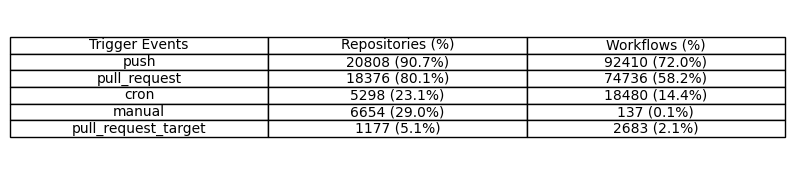

In [59]:
table_data = main(workflow_df)
